# Conversion Rate Project

This project is related to how to optimize the conversion rate. In this project, I will go through how to explore the data, how to build the model to predict the conversion rate, and finally, give out the recommendations about improving the conversion rate.

The data was about all users who hit our website: whether they converted or not as well as some of their charactistics such as their country, the marketing channel, their ages, whether they are repeated users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

# Index

* Part 1: Input the libraries and read data
* Part 2: Explore Data Analysis
* Part 3: Machine Learning - Model Building
  * Model building
  * Customer Segmentation

## Part 1: Input the libraries and read data

In [72]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [73]:
#read data

data = pd.read_csv("C:/Users/traci/conversion_project.csv")

In [74]:
# check the first 5 rows of the data

print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


__The variables in the dataset -__
1. country: user contry based on the IP address
2. age: user age. This was the data which self-reported by the customers at sign-up step.
3. new_user: Whether the user created the account during this session or had already an account and simply came back to the sit
4. Souce: marketing channel source
 * Ads: came to the site by clicking on an advertisement
 * Seo: case to the site by clicking on search results
 * Direct: came to the site by directly typing the URL on the brower
5. total_pages_visited: number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement
6. converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase rate: $rate = \frac{converstions}{total sessions}$

## Part 2: Explore Data Analysis

### 1. Describe the data

In [75]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [77]:
print(data.describe())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


In [78]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [79]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


####  Observations:

* The site is probably a US site, although it does have a large Chinese user base as well.
* User base is pretty young
* Conversion rate at around 3% is industry standard.
* Everything seems to make sense here except for max age 123 yrs!

### Remove Outliers

__Investigate the `age`__

In [80]:
print(sorted(data['age'].unique(), reverse = True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [81]:
# detect the records with the age which were outliers

print(data[data['age'] > 110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


There were two users. In this case, we can remove them, nothing will change. In general, depending on the problem, we can"
* remove the entire row saying you don't trust the data.
* treat them as NAs.
* If there is a pattern, try to figure out what went wrong.

That being said, wrong data is worrisome and can be an indicator of some bug in the logging code. Therefore, when working, you will want to talk to the software engineer who implemented the logging code to see if, perhaps, there are some bugs which affect the data significantly.

For this case, we just remove the two rows.

In [82]:
# revmoe the age beyond 110

data = data[data['age'] < 110]

### 2. Correlation Estimate

In [83]:
data.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.012445,-0.046093,-0.089199
new_user,0.012445,1.000000,-0.082522,-0.152338
total_pages_visited,-0.046093,-0.082522,1.000000,0.528975
converted,-0.089199,-0.152338,0.528975,1.000000


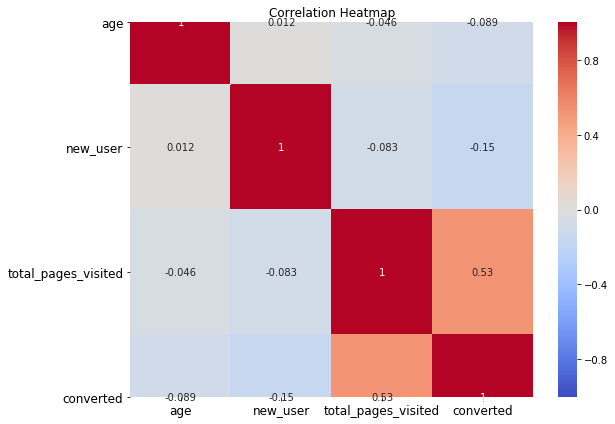

In [84]:
plt.figure(figsize = (9, 6))
s = sns.heatmap(data.corr(),
               annot = True,
               cmap = 'coolwarm',
               vmin = -1,
               vmax = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 0, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

### 3. Data distribution

Firstly, let's quickly investigate the variables and how their distribution differs for the two classes. This will help me understand whether their is any information in the data.

#### 1. Country

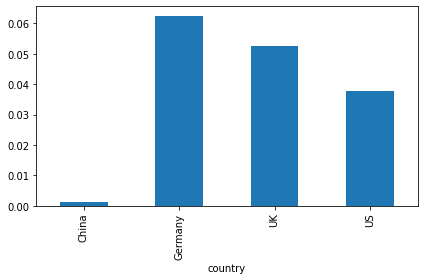

In [85]:
# Visualize the mean conversion rate across countries

data.groupby(data['country'])['converted'].mean().plot.bar()
plt.show()

#### Observations:

China had the lowest conversion rate.

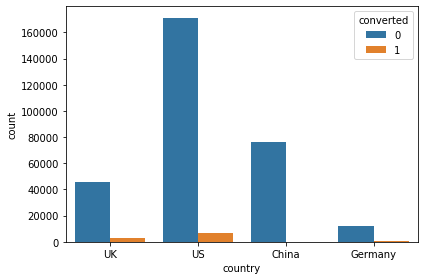

In [86]:
# visualized the conversion rate with the count of the country


sns.countplot(x = 'country', hue = 'converted', data = data)

#### 2. Total_pages_visited

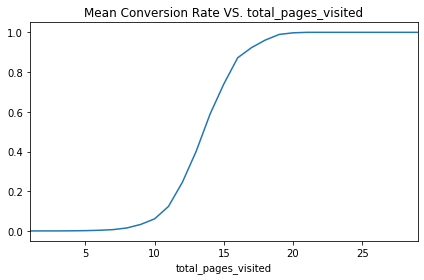

In [90]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.title("Mean Conversion Rate VS. total_pages_visited")
plt.show()

#### Observations:

Spending more time on the site implies higher probability of conversion.

#### 3. Age

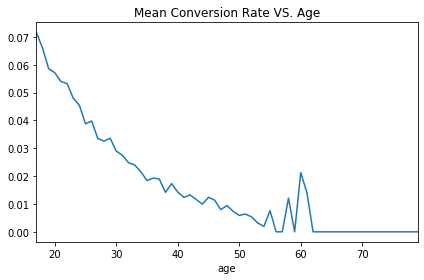

In [89]:
data.groupby(data['age'])['converted'].mean().plot()
plt.title("Mean Conversion Rate VS. Age")
plt.show()

#### Observations:

* As the ages increased, the probability of conversion decreased.
* But there was a conversion rate spark between age 55 and 60. 
* After age 60, the conversion rate dropped dramatically. 

#### 4. Source

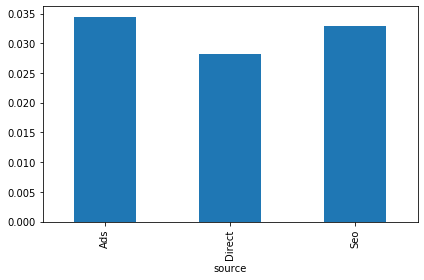

In [14]:
data.groupby(data['source'])['converted'].mean().plot.bar()
plt.show()

#### Observations:

* The users brought to the website by Ads had the highest probability of conversion.
* The users brought to the website by searching had the lowest probability of conversion.

## Part 3: Machine Learning - Model Building

Since the target is binary (0/1) and I care about the insights to give product and marketing team project ideas. I will choose amoung the following options - 
1. Logistic regression
2. Decision Trees
3. RuleFit
4. Random Forest or Boosted Decision Trees in combination with partial dependence plots

#### 1. Create the dummy variables for the categorical variables

In [15]:
data_dummy = pd.get_dummies(data, drop_first = True)

#### 2. Create the dummy variables for the categorical variables

Create test/training dataset with a standard 66% split (if the data were too small, I would cross-vaidate). Then I will build the random forest with standard values for the 3 important parameters (100 trees, trees as large as possible, 3 random variables selected as each split).

In [16]:
#split the data into traning dataset and testing dataset

np.random.seed(4686)

train, test = train_test_split(data_dummy, test_size = 0.34)

#build the model

rf = RandomForestClassifier(n_estimators = 100, max_features = 3, oob_score = True)
rf.fit(train.drop('converted', axis = 1), train['converted'])

#print OOB accuracy and confusion matrix

print(
"OOB accuracy is",
rf.oob_score_,
"\n"
"OOB Confusion Matrix",
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels = [0, 1]))
)

OOB accuracy is 0.9841247783794145 
OOB Confusion Matrix 
         0     1
0  200835  1088
1    2224  4543


In [17]:
#Print the test accuracy and confusion matrix

print(
"Test accuracy is", rf.score(test.drop('converted', axis = 1), test['converted']), 
"\n",
"Test Set Confusion Matrix",
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis = 1)), labels = [0, 1]))
)

Test accuracy is 0.9847453212784165 
 Test Set Confusion Matrix 
         0     1
0  103532   545
1    1095  2336


__Observations:__

OOB error and test error are pretty similar. We are confident that we are not overfitting.

Error is pretty low. However, we started from a 97% accuracy (that is the case if we classified everthing as a "non converted"). So 98.5% is good, but nothing shocking. Indeed, ~30% of conversion are predicted as "non conversion".

If we care about the very best possible accuracy or specifically minimizing false positive /false negative, we would find the best cut-off point. Since in this case that doesn't appear to be particularly relevant, we are find the default 0.5 cutoff value used internally by the random forest to make the prediction.

#### 3. Checking the variable importance

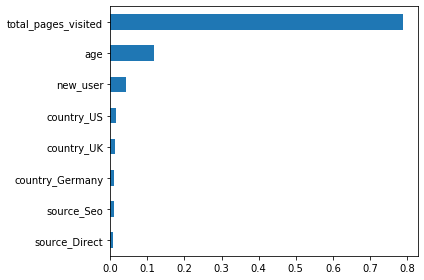

In [18]:
feat_importances = pd.Series(rf.feature_importances_, index = train.drop('converted', axis = 1).columns)
feat_importances.sort_values().plot(kind = 'barh')
plt.show()

__Observations:__

Total pages visited is the most important one, by far. Unfortunately, it is probably the least "actionable". People visit many pages because they already want to buy. Also, in order to buy, you have to click on multiple pages. Let's rebuild the RF without the `total pages visited` variable. Since classes are heavily unbalanced and we don't have the very powerful variable anymore, let's change the weights, jsut to make sure we will get something classified as 1.

Now, built the model without `total pages visited`.

In [19]:
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, oob_score = True, class_weight = {0:1, 1:10})

rf.fit(train.drop(['converted', 'total_pages_visited'], axis = 1), train['converted'])


print(
"OOB accuracy is",
rf.oob_score_,
"\n",
"OOB Confusion Matrix",
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:, 1].round(), labels = [0, 1])))

OOB accuracy is 0.8884182279936749 
 OOB Confusion Matrix 
         0      1
0  182330  19593
1    3693   3074


Check the variance importance.

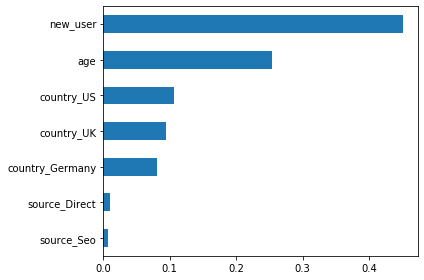

In [20]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

__Observations:__

1. `New_user` is the most important one, even more important than age. 
2. Follower `New_use` is the factor `age`. Based on the analysis, the main users were the people among the age of 20 to 30. As the `age` went up, the converted rate went down.


#### The End